In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split #分割資料
from sklearn.metrics import confusion_matrix

# keras 
import keras
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

In [2]:
#影像的輸入大小
im_W = 32
im_H = 32

#影像的輸入維度
datachannel = 1

#影像的path
class_path = r"face/size/total"

#影像該位置的所有檔案名稱
class_filenames = os.listdir(class_path)

#建立空陣列並定義大小，將給予輸入存取的空間：根據影像數量與輸入大小及維度
data = np.empty((len(class_filenames), im_W, im_H, datachannel), dtype="uint8")

#建立皆為0且檔案數量的label
label = [0] * len(class_filenames)

#塞制空陣列的輸入與label
for i in range(len(class_filenames)):
    
    #label根據檔案名字前一個字，取代之前建利皆為0的label
    if(int(class_filenames[i][0])==0):
        label[i] = 0
    if(int(class_filenames[i][0])==1):
        label[i] = 1
    if(int(class_filenames[i][0])==2):
        label[i] = 2
    if(int(class_filenames[i][0])==3):
        label[i] = 3
    if(int(class_filenames[i][0])==4):
        label[i] = 4
    if(int(class_filenames[i][0])==5):
        label[i] = 5
    if(int(class_filenames[i][0])==6):
        label[i] = 6
    if(int(class_filenames[i][0])==7):
        label[i] = 7
    if(int(class_filenames[i][0])==8):
        label[i] = 8
    
    #每一影像讀取並轉呈灰階
    img = Image.open(class_path + "/" + class_filenames[i]).convert("L")
    
    #將該影像轉成陣列
    npimg = np.asarray(img, dtype="uint8")
    
    #持續將影像陣列蓋掉之前空陣列
    data[i,:,:,0] = npimg

In [3]:
#打印出影像的維度與標籤的維度
print("影像的維度：", data.shape)
print("標籤的維度：", len(label))

#影像分割訓練集與測試集
x_train, x_test, y_train_noonehot, y_test_noonehot = train_test_split(data, label, test_size = 0.3, random_state = 0) 

#打印出訓練集與測試集的每個類別數量
print("訓練集標籤數量：%s" %(len(y_train_noonehot)))
print("訓練集標籤的類別數量：",Counter(y_train_noonehot))
print("訓練集標籤數量：%s" %(len(y_test_noonehot)))
print("測試集標籤的類別數量：",Counter(y_test_noonehot))

#將Label轉為One-hot-encode
y_train = pd.get_dummies(pd.Series(y_train_noonehot)).values.astype('float32')
y_test = pd.get_dummies(pd.Series(y_test_noonehot)).values.astype('float32')

影像的維度： (3144, 32, 32, 1)
標籤的維度： 3144
訓練集標籤數量：2200
訓練集標籤的類別數量： Counter({1: 408, 0: 352, 2: 342, 6: 283, 7: 251, 8: 188, 4: 145, 5: 144, 3: 87})
訓練集標籤數量：944
測試集標籤的類別數量： Counter({1: 168, 0: 159, 6: 149, 2: 119, 7: 110, 8: 80, 4: 74, 5: 47, 3: 38})


In [4]:
#影像正規化
x_train = x_train.astype('float32')
x_train /= 255

x_test = x_test.astype('float32')
x_test /= 255

In [5]:
#宣告模型
model = Sequential()

#輸入層與第一個隱藏層
model.add(Conv2D(filters=8,kernel_size=(5, 5), input_shape=(im_W, im_H, datachannel),activation='relu'))
model.add(Dropout(0.3))

#第二個隱藏層
model.add(Conv2D(filters=16,kernel_size=(5, 5),activation='relu'))
model.add(Dropout(0.3))

#第三個隱藏層
model.add(Conv2D(filters=16,kernel_size=(5, 5),activation='relu'))
model.add(Dropout(0.3))

#第四個隱藏層
model.add(Conv2D(filters=32,kernel_size=(5, 5),activation='relu'))
model.add(Dropout(0.3))

#全連接層
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

#輸出層(共九個類別)
model.add(Dense(9 , activation='softmax'))

#定義使用的損失函數 與 優化器 以及 要顯示的指標
model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

#打印出目前已宣告好的模型
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        3216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        1

In [6]:
#開始訓練模型
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=30, verbose=2)

#模型儲存
model.save(r"model/modelunsharpgb_out.h5")

Epoch 1/30
22/22 - 2s - loss: 1.6474 - accuracy: 0.3836 - val_loss: 0.4938 - val_accuracy: 0.9025
Epoch 2/30
22/22 - 2s - loss: 0.3535 - accuracy: 0.8905 - val_loss: 0.1226 - val_accuracy: 0.9693
Epoch 3/30
22/22 - 2s - loss: 0.1281 - accuracy: 0.9618 - val_loss: 0.0236 - val_accuracy: 0.9936
Epoch 4/30
22/22 - 2s - loss: 0.0563 - accuracy: 0.9859 - val_loss: 0.0348 - val_accuracy: 0.9905
Epoch 5/30
22/22 - 2s - loss: 0.0439 - accuracy: 0.9873 - val_loss: 0.0083 - val_accuracy: 0.9989
Epoch 6/30
22/22 - 2s - loss: 0.0308 - accuracy: 0.9905 - val_loss: 0.0144 - val_accuracy: 0.9958
Epoch 7/30
22/22 - 2s - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.0079 - val_accuracy: 0.9989
Epoch 8/30
22/22 - 2s - loss: 0.0174 - accuracy: 0.9941 - val_loss: 0.0103 - val_accuracy: 0.9989
Epoch 9/30
22/22 - 2s - loss: 0.0119 - accuracy: 0.9955 - val_loss: 0.0149 - val_accuracy: 0.9979
Epoch 10/30
22/22 - 2s - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 11/30
22/22 -

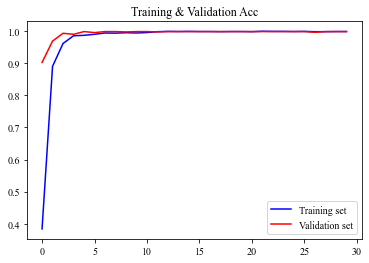

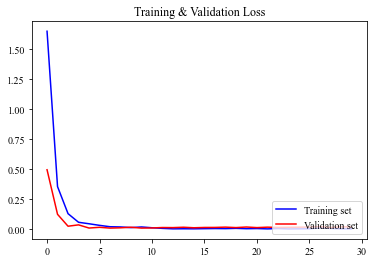

In [7]:
# 繪出學習曲線
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title("Training & Validation Acc")
plt.plot(np.arange(len(acc)), acc,color='b', label="Training set")
plt.plot(np.arange(len(val_acc)), val_acc,color='r', label="Validation set")
plt.legend(loc='lower right')
plt.show()

plt.title("Training & Validation Loss")
plt.plot(np.arange(len(loss)), loss,color='b', label="Training set")
plt.plot(np.arange(len(val_loss)), val_loss,color='r', label="Validation set")
plt.legend(loc='lower right')
plt.show()

In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,size = 22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 18)
    plt.yticks(tick_marks, classes, size = 18)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size = 15)

    plt.ylabel('True label',size = 20)
    plt.xlabel('Predicted label',size = 20)
    plt.tight_layout()
    plt.savefig("Confusion_matrix.png")
    plt.show()

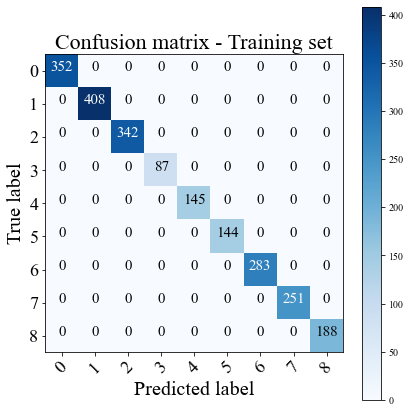

In [11]:
#訓練集
probabilities = model.predict(x_train)
predict = model.predict_classes(x_train)

cnf_matrix = confusion_matrix(y_train_noonehot, predict)
target_names = np.arange(0,9,1).astype(str)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix - Training set', cmap=plt.cm.Blues)

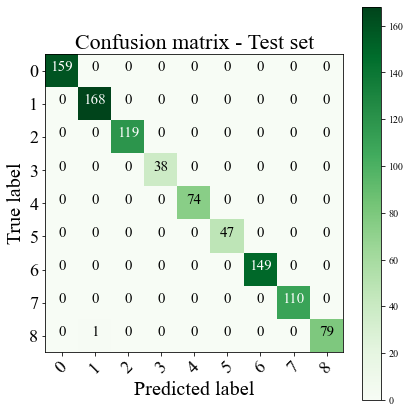

In [12]:
#測試集

probabilities = model.predict(x_test)
predict = model.predict_classes(x_test)

cnf_matrix = confusion_matrix(y_test_noonehot, predict)
target_names = np.arange(0,9,1).astype(str)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix - Test set', cmap=plt.cm.Greens)

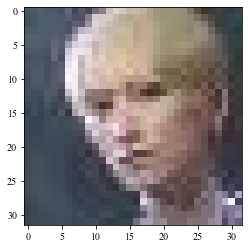

預測為： 0
預測機率為： [1.0000000e+00 4.5794918e-10 1.9793817e-16 2.3082754e-14 4.7920722e-23
 6.2048477e-11 4.4917632e-18 1.7344927e-14 4.5580414e-12]


In [17]:
#測試用

#加載模型
model = keras.models.load_model('model/modelunsharpgb_out.h5')

#讀測試影像
image = cv2.imread(r"face/size/total/0 -  (1).jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image,(32,32),interpolation=cv2.INTER_CUBIC)
npimg = np.asarray(image, dtype="uint8")
data = np.empty((32, 32, 1), dtype="uint8")

data[:,:,0] = npimg
data = data.astype('float32')
data /= 255
data = data.reshape((1, 32, 32, 1)) 
faceID = model.predict_classes(data) 
print("預測為：",faceID[0])
faceID = model.predict(data) 
print("預測機率為：",faceID[0])